In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import pandas as pd
import matplotlib.pyplot as plt  # For 2D visualization
import seaborn as sns
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Imputer
from sklearn import preprocessing


In [2]:
train_data = pd.read_csv("datasets/train.csv")
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)
train_data.SalePrice = np.log1p(train_data.SalePrice)
test_data = pd.read_csv('datasets/test.csv')
merged_data = pd.concat([train_data, test_data], ignore_index = True)

train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 0 to 1459
Data columns (total 81 columns):
Id               1458 non-null int64
MSSubClass       1458 non-null int64
MSZoning         1458 non-null object
LotFrontage      1199 non-null float64
LotArea          1458 non-null int64
Street           1458 non-null object
Alley            91 non-null object
LotShape         1458 non-null object
LandContour      1458 non-null object
Utilities        1458 non-null object
LotConfig        1458 non-null object
LandSlope        1458 non-null object
Neighborhood     1458 non-null object
Condition1       1458 non-null object
Condition2       1458 non-null object
BldgType         1458 non-null object
HouseStyle       1458 non-null object
OverallQual      1458 non-null int64
OverallCond      1458 non-null int64
YearBuilt        1458 non-null int64
YearRemodAdd     1458 non-null int64
RoofStyle        1458 non-null object
RoofMatl         1458 non-null object
Exterior1st      1458 non-n

/home/johnson/python_venv/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [3]:
def outliers(variable):
    # Calculate 1st, 3rd quartiles and iqr.
    q1, q3 = variable.quantile(0.25), variable.quantile(0.75)
    iqr = q3 - q1
    # Calculate lower fence and upper fence for outliers
    l_fence, u_fence = q1 - 1.5*iqr , q3 + 1.5*iqr   # Any values less than l_fence and greater than u_fence are outliers.
    # Observations that are outliers
    outliers = variable[(variable<l_fence) | (variable>u_fence)]
    print('Total Outliers of', variable.name,':', outliers.count())
    # Drop obsevations that are outliers
    filtered = variable.drop(outliers.index, axis = 0)
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2,1)
    # Gives space between two subplots
    fig.subplots_adjust(hspace = 1) 
    # Plot variable with outliers
    variable.plot.box(vert = False, color = 'coral', grid = False, ax = ax1, title = 'Distribution with Outliers for %s' %variable.name)
    # Plot variable without outliers
    filtered.plot.box(vert = False, color = 'coral', grid = False, ax = ax2, title = 'Distribution without Outliers for %s' %variable.name)


('Total Outliers of', 'SalePrice', ':', 28)


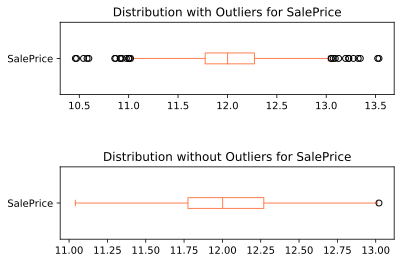

In [4]:
outliers(train_data.SalePrice)

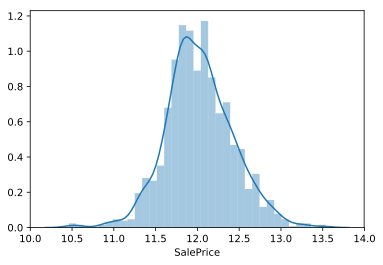

In [5]:
sns.distplot(train_data.SalePrice)

In [6]:
merged_data.MSSubClass.value_counts()

20     1079
60      573
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

'There are 0 missing values'

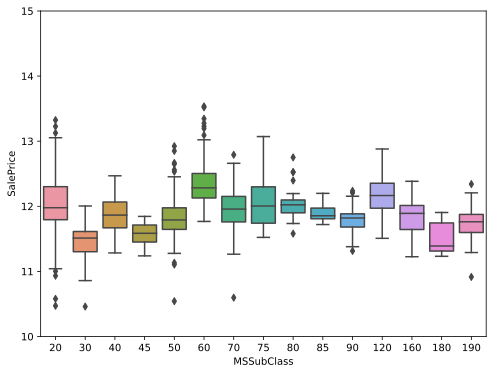

In [7]:
var = 'MSSubClass'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=train_data)
fig.axis(ymin=10, ymax=15)

missing_counts = merged_data.MSSubClass.shape[0] - merged_data.MSSubClass.count()
display("There are %d missing values" % missing_counts)

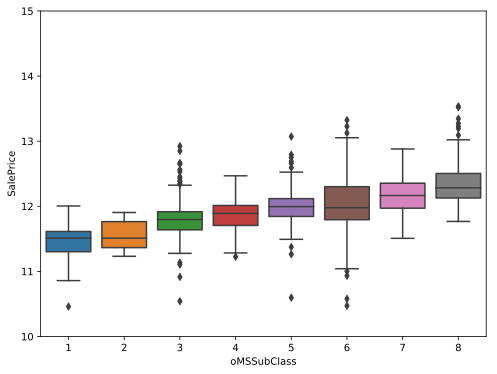

In [8]:
merged_data['oMSSubClass'] = merged_data.MSSubClass.map({180:2, 
                                        30:1, 45:2, 
                                        190:3, 50:3, 90:3, 
                                        85:4, 40:4, 160:4, 
                                        70:5, 20:6, 75:5, 80:5, 150:5,
                                        120: 7, 60:8})

var = 'oMSSubClass'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=merged_data)
fig.axis(ymin=10, ymax=15)

train_data=merged_data.loc[merged_data['SalePrice'].notnull()]
test_data=merged_data.loc[merged_data['SalePrice'].isnull()]


'There are 0 missing values'

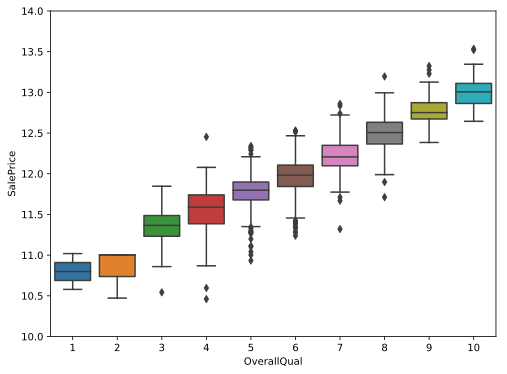

In [9]:
var = 'OverallQual'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=train_data)
fig.axis(ymin=10, ymax=14)
missing_counts = merged_data.OverallQual.shape[0] - merged_data.OverallQual.count()
display("There are %d missing values" % missing_counts)

'There are 0 missing values'

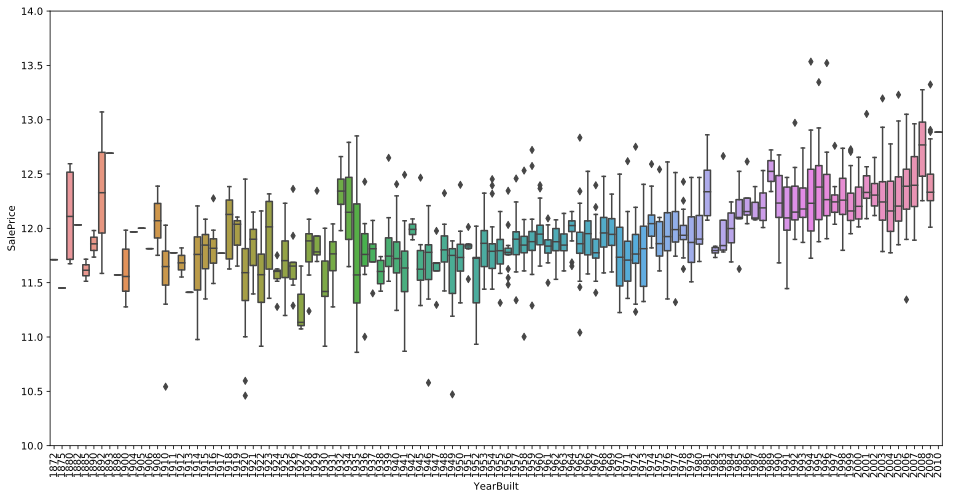

In [10]:
var = 'YearBuilt'
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=train_data)
fig.axis(ymin=10, ymax=14);
plt.xticks(rotation=90);
missing_counts = merged_data[var].shape[0] - merged_data[var].count()
display("There are %d missing values" % missing_counts)

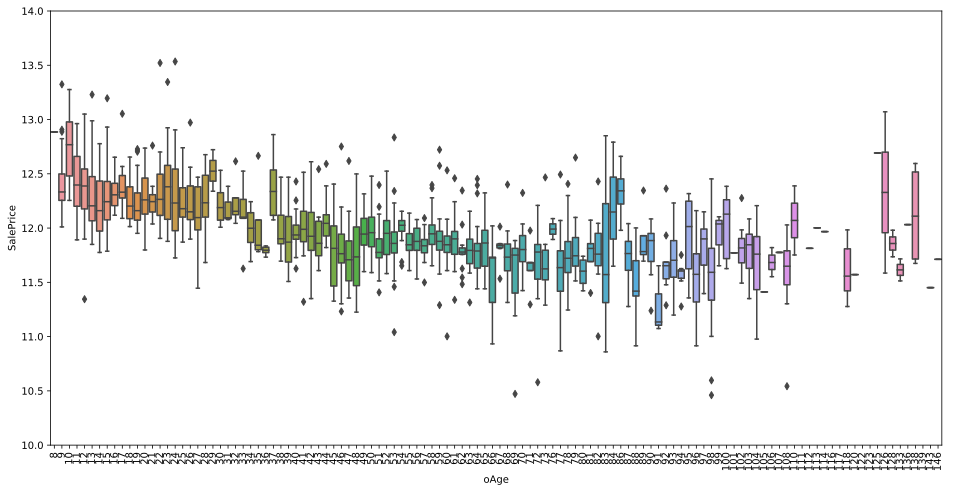

In [11]:
merged_data['oAge'] = 2018 - merged_data['YearBuilt']
merged_data.oAge.value_counts()
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x='oAge', y="SalePrice", data=merged_data)
fig.axis(ymin=10, ymax=14)
plt.xticks(rotation=90)

train_data = merged_data.loc[merged_data.SalePrice.notna()]
test_data = merged_data.loc[merged_data.SalePrice.notna()]

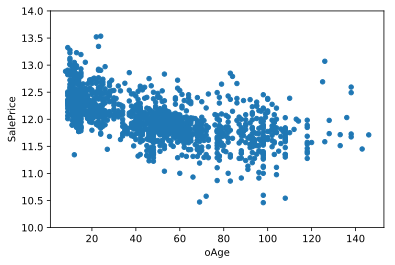

In [12]:
merged_data.plot.scatter(x='oAge', y='SalePrice', ylim=(10,14))

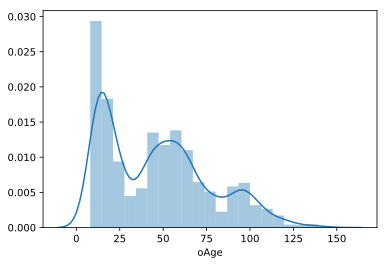

In [13]:
sns.distplot(merged_data['oAge'])

In [14]:
#########################################
# TotalBsmtSF, BsmtFullBath, BsmtHalfBath
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1
# BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF
#########################################
for var in ['TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual',
            'BsmtCond','BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
           'BsmtFinType2','BsmtFinSF2', 'BsmtUnfSF']:
  
    missing_counts = merged_data[var].shape[0] - merged_data[var].count()
    display("There are %d missing values in %s" % (missing_counts,var))


'There are 1 missing values in TotalBsmtSF'

'There are 2 missing values in BsmtFullBath'

'There are 2 missing values in BsmtHalfBath'

'There are 81 missing values in BsmtQual'

'There are 82 missing values in BsmtCond'

'There are 82 missing values in BsmtExposure'

'There are 79 missing values in BsmtFinType1'

'There are 1 missing values in BsmtFinSF1'

'There are 80 missing values in BsmtFinType2'

'There are 1 missing values in BsmtFinSF2'

'There are 1 missing values in BsmtUnfSF'

In [15]:
merged_data.BsmtQual.fillna("NA", inplace=True)
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

merged_data.BsmtCond.fillna("NA", inplace=True)
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

merged_data.BsmtExposure.fillna("NA", inplace=True)
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

merged_data.BsmtFinType1.fillna("NA", inplace=True)
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

merged_data.BsmtFinType2.fillna("NA", inplace=True)
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

#these 2 missing values have no basement
merged_data.loc[merged_data.BsmtFullBath.isna()].BsmtFinType1
merged_data.BsmtFullBath.fillna(0, inplace=True)
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

#
merged_data.BsmtHalfBath.fillna(0, inplace=True)
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

#
merged_data.TotalBsmtSF.fillna(0, inplace=True)
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

merged_data.BsmtFinSF1.fillna(0, inplace=True)
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

merged_data.BsmtFinSF2.fillna(0, inplace=True)
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

merged_data.BsmtUnfSF.fillna(0, inplace=True)
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

In [16]:
merged_data.loc[merged_data.BsmtUnfSF.isna()].BsmtFinType1

Series([], Name: BsmtFinType1, dtype: object)

'There are 0 missing values'

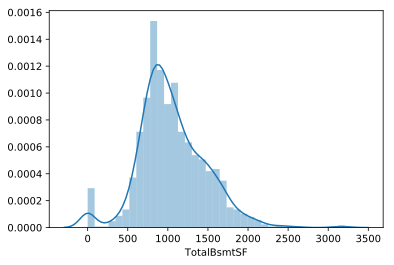

In [17]:
var = 'TotalBsmtSF'

sns.distplot(train_data['TotalBsmtSF'])
missing_counts = merged_data.TotalBsmtSF.shape[0] - merged_data.TotalBsmtSF.count()
display("There are %d missing values" % missing_counts)

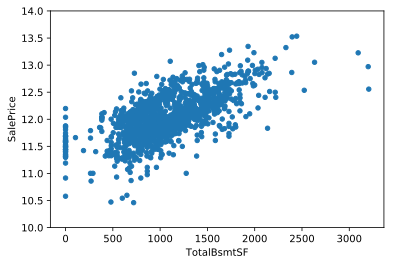

In [18]:
train_data.plot.scatter(x=var, y='SalePrice', ylim=(10,14))
merged_data.TotalBsmtSF.fillna(0, inplace=True)
train_data = merged_data.loc[merged_data.SalePrice.notna()]
test_data = merged_data.loc[merged_data.SalePrice.notna()]

'There are 0 missing values'

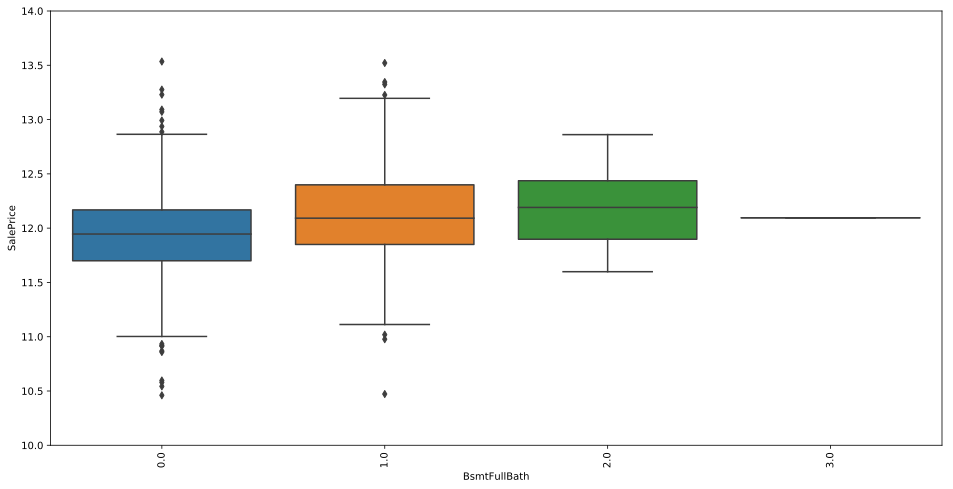

In [19]:
var = 'BsmtFullBath'
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=merged_data)
fig.axis(ymin=10, ymax=14);
plt.xticks(rotation=90);
display("There are %d missing values" % missing_counts)
merged_data.loc[merged_data.BsmtFullBath.isna(), ['Id', 'TotalBsmtSF']]
merged_data.BsmtFullBath.fillna(0, inplace=True)
missing_counts = merged_data[var].shape[0] - merged_data[var].count()

In [20]:
#########################################
# OverallQual, OverallCond
#########################################
for var in ['OverallQual', 'OverallCond']:
    missing_counts = merged_data[var].shape[0] - merged_data[var].count()
    display("There are %d missing values in %s" % (missing_counts,var))

'There are 0 missing values in OverallQual'

'There are 0 missing values in OverallCond'

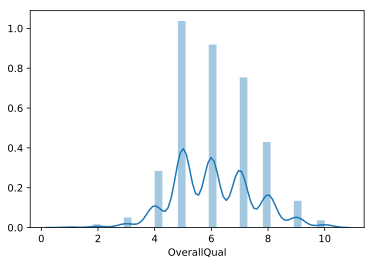

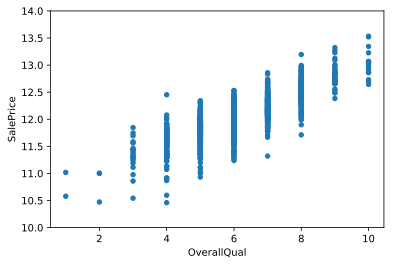

In [21]:
sns.distplot(merged_data['OverallQual'])
merged_data.OverallQual.value_counts()
merged_data.plot.scatter(x='OverallQual', y='SalePrice', ylim=(10,14))

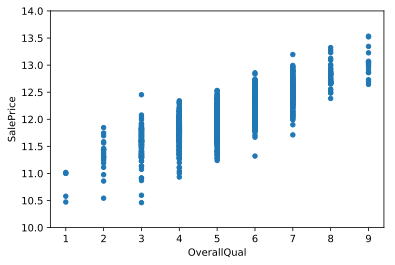

In [22]:
merged_data.OverallQual = merged_data.OverallQual.apply(lambda x: 1 if (x<=2) else x-1)
merged_data.plot.scatter(x='OverallQual', y='SalePrice', ylim=(10,14))

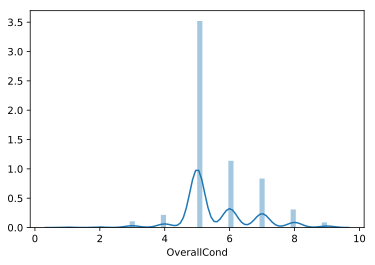

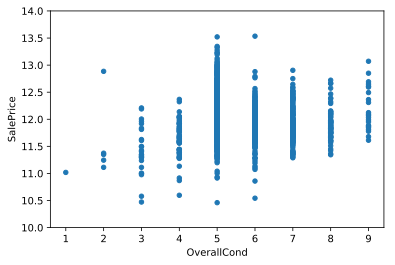

In [23]:
sns.distplot(merged_data['OverallCond'])
merged_data.plot.scatter(x='OverallCond', y='SalePrice', ylim=(10,14))

In [24]:
merged_data.OverallCond = merged_data.OverallCond.apply(lambda x: 1 if (x<=2) else x-1)

In [25]:
merged_data.OverallCond.value_counts()

4    1643
5     531
6     390
7     144
3     101
2      50
8      41
1      17
Name: OverallCond, dtype: int64

In [26]:
#########################################
# LotArea, LotFrontage, LotShape, LotConfig
#########################################
for var in ['LotArea', 'LotShape', 'LotFrontage', 'LotConfig']:
    missing_counts = merged_data[var].shape[0] - merged_data[var].count()
    display("There are %d missing values in %s" % (missing_counts,var))

'There are 0 missing values in LotArea'

'There are 0 missing values in LotShape'

'There are 486 missing values in LotFrontage'

'There are 0 missing values in LotConfig'

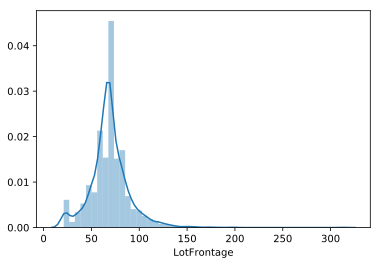

In [27]:
merged_data.LotFrontage.fillna(merged_data.LotFrontage.median(), inplace=True)
train_data = merged_data.loc[merged_data.SalePrice.notna()]
test_data = merged_data.loc[merged_data.SalePrice.isna()]
sns.distplot(merged_data.LotFrontage)


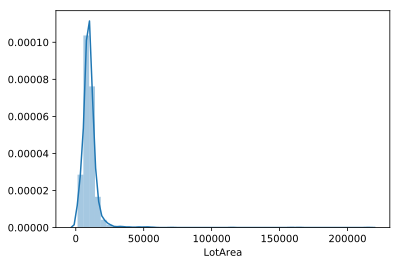

In [28]:
sns.distplot(merged_data.LotArea)

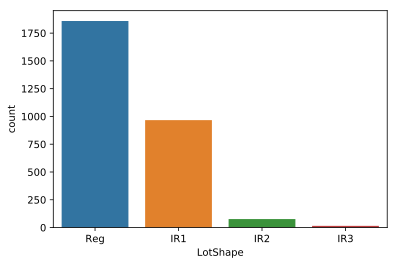

In [29]:
sns.countplot(merged_data.LotShape)

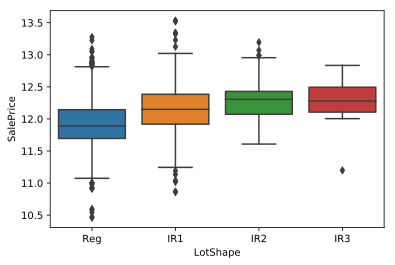

In [30]:
var='LotShape'
fig = sns.boxplot(x=var, y="SalePrice", data=merged_data)

In [31]:
merged_data.LotShape = merged_data.LotShape.map({'IR3':3, 'IR2':3, 'IR1':2, 'Reg':1})
train_data = merged_data.loc[merged_data.SalePrice.notna()]
test_data = merged_data.loc[merged_data.SalePrice.isna()]

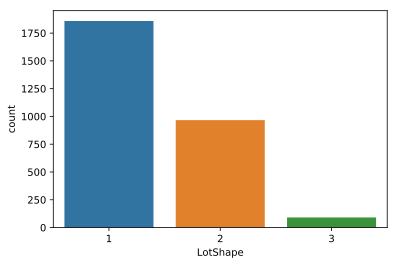

In [32]:
var='LotConfig'
sns.countplot(merged_data.LotShape)


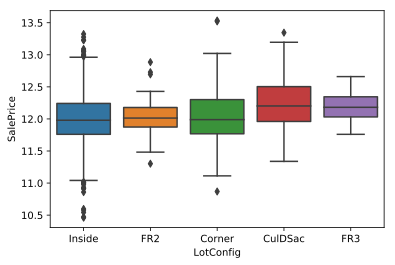

In [33]:
fig = sns.boxplot(x=var, y="SalePrice", data=merged_data)

In [34]:
merged_data.LotConfig = merged_data.LotConfig.map({'Corner LotConfig':3, 'CulDSac':3, 'FR3':3, 'FR2':2, 'Inside':1})
train_data = merged_data.loc[merged_data.SalePrice.notna()]
test_data = merged_data.loc[merged_data.SalePrice.isna()]

In [35]:
###################################
#SaleType,SaleCondition
###################################
for var in ['SaleType', 'SaleCondition']:
    missing_counts = merged_data[var].shape[0] - merged_data[var].count()
    display("There are %d missing values in %s" % (missing_counts,var))

'There are 1 missing values in SaleType'

'There are 0 missing values in SaleCondition'

In [36]:
merged_data.loc[merged_data.SaleType.isna()].SaleCondition
merged_data.SaleType.value_counts()


WD       2525
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

In [37]:
merged_data["SaleType"] = merged_data.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':2, 'ConLw':2, 'Oth':1, 'WD':2,
                                       'CWD':2, 'Con':3, 'New':3})
train_data = merged_data.loc[merged_data.SalePrice.notna()]
test_data = merged_data.loc[merged_data.SalePrice.isna()]


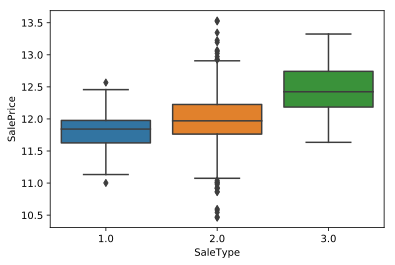

In [38]:
fig = sns.boxplot(x='SaleType', y="SalePrice", data=train_data)


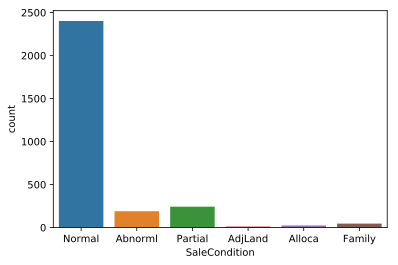

In [39]:
var='SaleCondition'

sns.countplot(merged_data.SaleCondition)

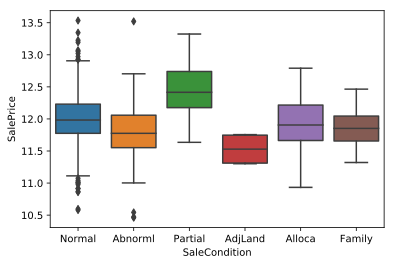

In [40]:
fig = sns.boxplot(x='SaleCondition', y="SalePrice", data=train_data)


In [41]:
###################################
#MoSold,YrSold
###################################
for var in ['MoSold', 'YrSold']:
    missing_counts = merged_data[var].shape[0] - merged_data[var].count()
    display("There are %d missing values in %s" % (missing_counts,var))


'There are 0 missing values in MoSold'

'There are 0 missing values in YrSold'

In [42]:
merged_data['Date_sold'] = merged_data['YrSold'].astype(str) +'.'+ merged_data['MoSold'].astype(str)
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data = merged_data.loc[merged_data.SalePrice.isna()]

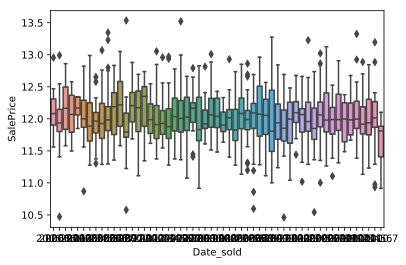

In [43]:
fig = sns.boxplot(x='Date_sold', y="SalePrice", data=merged_data)

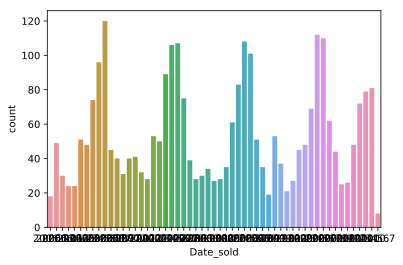

In [44]:
sns.countplot(merged_data.Date_sold)

In [45]:
###################################
#GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
###################################
for var in ['GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageArea','GarageQual','GarageCond']:
    missing_counts = merged_data[var].shape[0] - merged_data[var].count()
    display("There are %d missing values in %s" % (missing_counts,var))


'There are 157 missing values in GarageType'

'There are 159 missing values in GarageYrBlt'

'There are 159 missing values in GarageFinish'

'There are 1 missing values in GarageCars'

'There are 1 missing values in GarageArea'

'There are 159 missing values in GarageQual'

'There are 159 missing values in GarageCond'

In [46]:
merged_data.loc[merged_data.GarageType.isna(),'GarageYrBlt']="0"
merged_data.loc[merged_data.GarageType.isna(),'GarageFinish']="NA"
merged_data.loc[merged_data.GarageType.isna(),'GarageCars']="0"
merged_data.loc[merged_data.GarageType.isna(),'GarageQual']="NA"
merged_data.loc[merged_data.GarageType.isna(),'GarageCond']="NA"
merged_data.loc[merged_data.GarageType.isna(),'GarageType']="NA"


In [47]:
merged_data.loc[merged_data.GarageArea.isna(), 'GarageCars'] = 0
merged_data.loc[merged_data.GarageArea.isna(), 'GarageCond'] = "NA"
merged_data.loc[merged_data.GarageArea.isna(), 'GarageQual'] = "NA"
merged_data.loc[merged_data.GarageArea.isna(), 'GarageFinish'] ="NA"
merged_data.loc[merged_data.GarageArea.isna(), 'GarageYrBlt'] = 0
merged_data.loc[merged_data.GarageArea.isna(), 'GarageArea'] = 0

In [48]:
merged_data.loc[merged_data.GarageQual.isna(), 'GarageCond'] = merged_data.loc[merged_data.GarageCars==1,'GarageCond'].mode()[0]
merged_data.loc[merged_data.GarageQual.isna(), 'GarageFinish'] = merged_data.loc[merged_data.GarageCars==1,'GarageFinish'].mode()[0]
merged_data.loc[merged_data.GarageQual.isna(), 'GarageYrBlt'] = merged_data.loc[merged_data.GarageCars==1,'GarageYrBlt'].mode()[0]
merged_data.loc[merged_data.GarageQual.isna(), 'GarageQual'] = merged_data.loc[merged_data.GarageCars==1,'GarageQual'].mode()[0]
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]


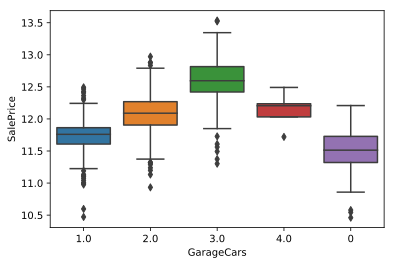

In [49]:
fig = sns.boxplot(x='GarageCars', y="SalePrice", data=train_data)


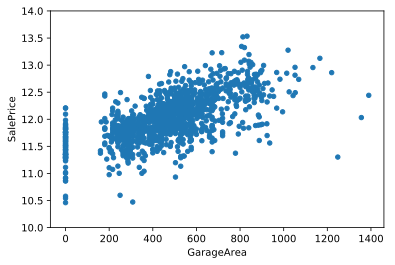

In [50]:
train_data.plot.scatter(x='GarageArea', y='SalePrice', ylim=(10,14))

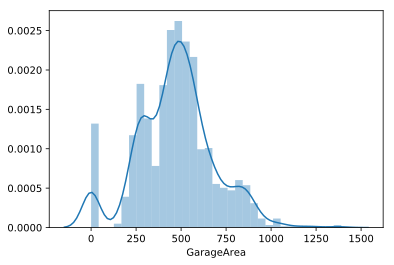

In [51]:
sns.distplot(train_data.GarageArea)

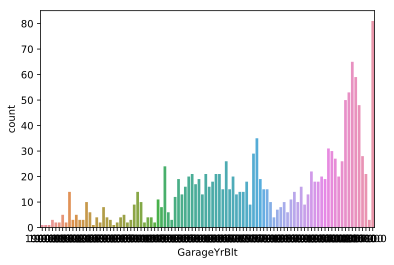

In [52]:
sns.countplot(train_data.GarageYrBlt)

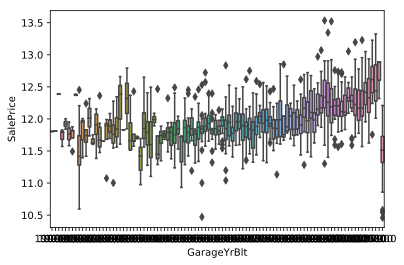

In [53]:
sns.boxplot(x='GarageYrBlt', y='SalePrice', data=train_data)

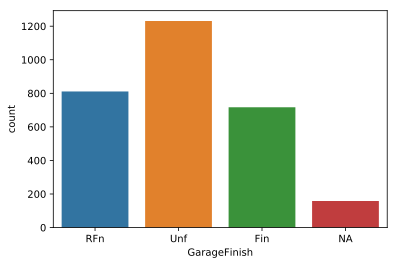

In [54]:
sns.countplot(merged_data.GarageFinish)

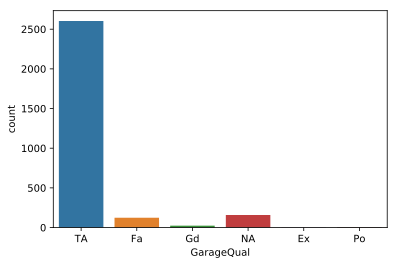

In [55]:
sns.countplot(merged_data.GarageQual)

In [56]:
merged_data.GarageQual.value_counts()

TA    2603
NA     158
Fa     124
Gd      24
Po       5
Ex       3
Name: GarageQual, dtype: int64

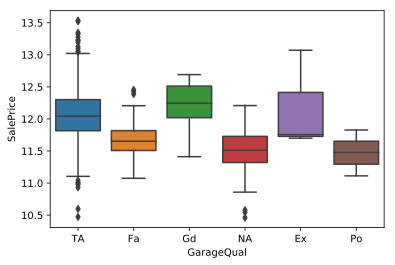

In [57]:
sns.boxplot(x='GarageQual', y='SalePrice', data=train_data)


In [58]:
merged_data['GarageQual'] = merged_data.GarageQual.map({'Po':0, 'NA':0,'Fa':0, 'TA':1, 'Gd':2,'Ex':2})
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

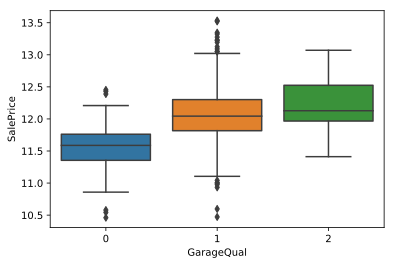

In [59]:
sns.boxplot(x='GarageQual', y='SalePrice', data=train_data)


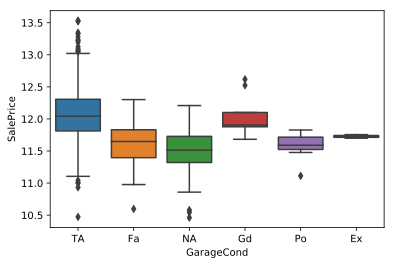

In [60]:
sns.boxplot(x='GarageCond', y='SalePrice', data=train_data)

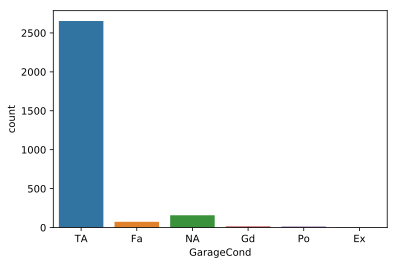

In [61]:
sns.countplot(merged_data.GarageCond)

In [62]:
merged_data.GarageCond.value_counts()


TA    2653
NA     158
Fa      74
Gd      15
Po      14
Ex       3
Name: GarageCond, dtype: int64

In [63]:
merged_data['GarageCond'] = merged_data.GarageCond.map({'NA':0, 'Fa':1, 'Po':1, 'TA':2,'Ex':1,'Gd':2})
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]


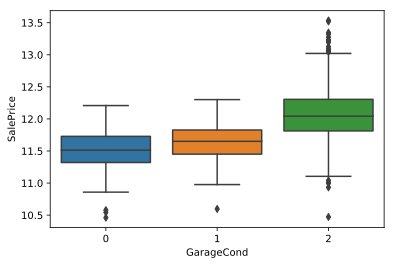

In [64]:
sns.boxplot(x='GarageCond', y='SalePrice', data=train_data)

In [65]:
#####################################################
# 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, Bedroom, Kitchen, KitchenQual, TotRmsAbvGrd
#####################################################
for var in ['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd']:
    missing_counts = merged_data[var].shape[0] - merged_data[var].count()
    display("There are %d missing values in %s" % (missing_counts,var))



'There are 0 missing values in 1stFlrSF'

'There are 0 missing values in 2ndFlrSF'

'There are 0 missing values in LowQualFinSF'

'There are 0 missing values in GrLivArea'

'There are 0 missing values in BedroomAbvGr'

'There are 0 missing values in KitchenAbvGr'

'There are 1 missing values in KitchenQual'

'There are 0 missing values in TotRmsAbvGrd'

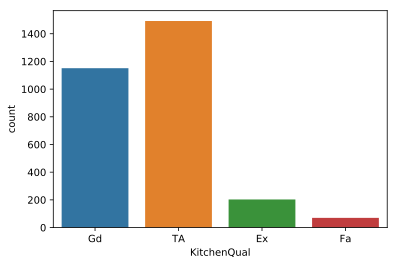

In [66]:
sns.countplot(merged_data.KitchenQual)

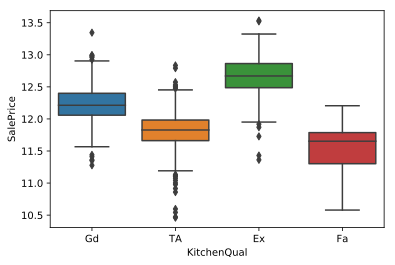

In [67]:
sns.boxplot(x='KitchenQual', y='SalePrice', data=train_data)

In [68]:
merged_data.loc[merged_data.KitchenQual.isna(), 'KitchenAbvGr']

1553    1
Name: KitchenAbvGr, dtype: int64

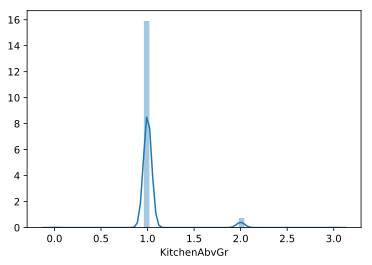

In [69]:
sns.distplot(merged_data.KitchenAbvGr)

In [70]:
merged_data.loc[merged_data.KitchenQual.isna(),'KitchenQual']=merged_data.loc[merged_data.KitchenAbvGr==1,'KitchenQual'].mode()[0]

In [71]:
merged_data['KitchenQual'] = merged_data.KitchenQual.map({'Fa':0, 'TA':1, 'Gd':2, 'Ex':3})
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

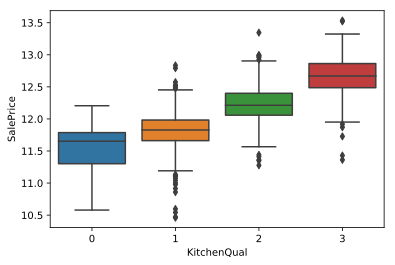

In [72]:
sns.boxplot(x='KitchenQual', y='SalePrice', data=train_data)

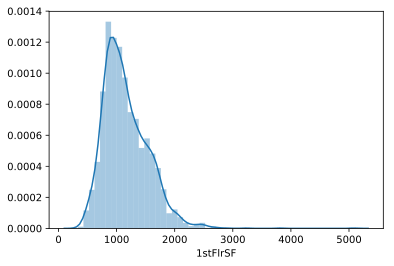

In [73]:
var = '1stFlrSF'
sns.distplot(merged_data[var])

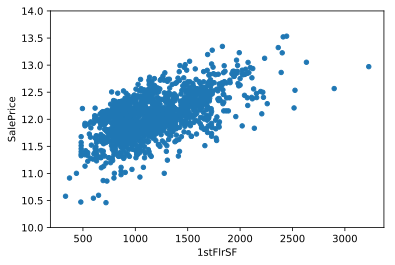

In [74]:
train_data.plot.scatter(x=var, y='SalePrice', ylim=(10,14))

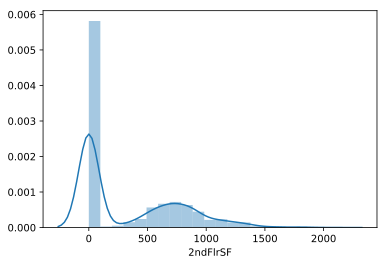

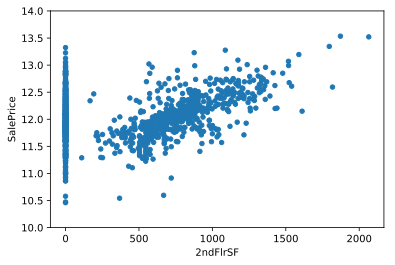

In [75]:
var = '2ndFlrSF'
sns.distplot(merged_data[var])
plt.show()
train_data.plot.scatter(x=var, y='SalePrice', ylim=(10,14))

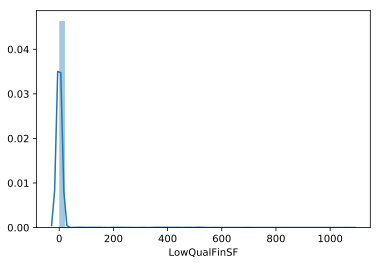

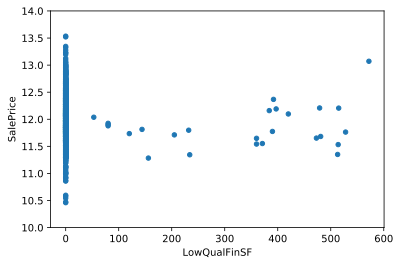

In [76]:
var = 'LowQualFinSF'
sns.distplot(merged_data[var])
plt.show()
train_data.plot.scatter(x=var, y='SalePrice', ylim=(10,14))

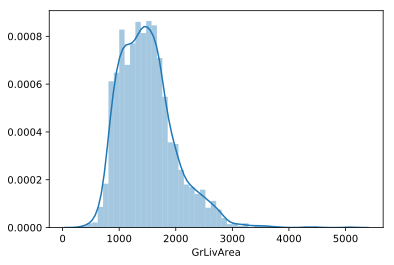

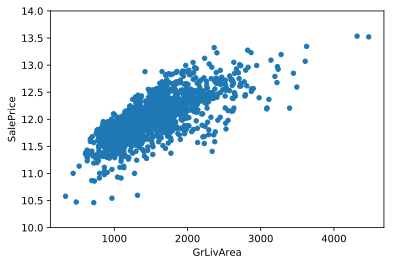

In [77]:
var = 'GrLivArea'
sns.distplot(merged_data[var])
plt.show()
train_data.plot.scatter(x=var, y='SalePrice', ylim=(10,14))

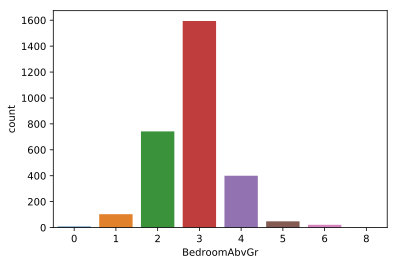

3    802
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

3    792
2    384
4    187
1     53
5     27
6     14
0      2
Name: BedroomAbvGr, dtype: int64

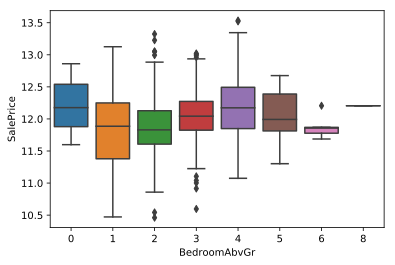

In [78]:
var = 'BedroomAbvGr'
sns.countplot(merged_data[var])
plt.show()
sns.boxplot(x=var, y='SalePrice', data=train_data)
display(train_data[var].value_counts())
display(test_data[var].value_counts())

In [79]:
merged_data = merged_data[merged_data.BedroomAbvGr!=8]
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

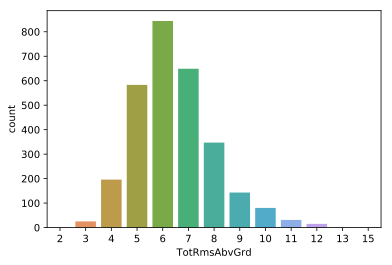

6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     17
3      17
12     10
2       1
Name: TotRmsAbvGrd, dtype: int64

6     442
7     320
5     308
8     160
4      99
9      68
10     33
11     14
3       8
12      5
15      1
13      1
Name: TotRmsAbvGrd, dtype: int64

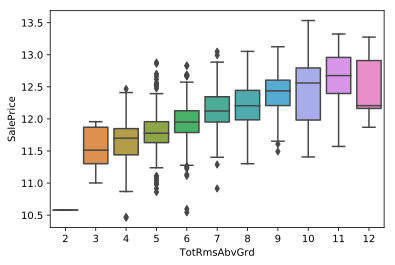

In [80]:
var = 'TotRmsAbvGrd'
sns.countplot(merged_data[var])
plt.show()
sns.boxplot(x=var, y='SalePrice', data=train_data)
display(train_data[var].value_counts())
display(test_data[var].value_counts())

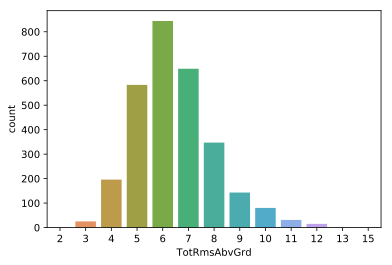

6     402
7     329
5     275
8     187
4      97
9      75
10     47
11     17
3      17
12     10
2       1
Name: TotRmsAbvGrd, dtype: int64

6     442
7     320
5     308
8     160
4      99
9      68
10     33
11     14
3       8
12      5
15      1
13      1
Name: TotRmsAbvGrd, dtype: int64

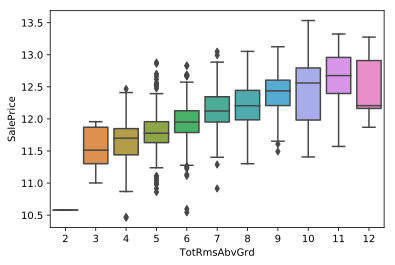

In [81]:
var = 'TotRmsAbvGrd'
sns.countplot(merged_data[var])
plt.show()
sns.boxplot(x=var, y='SalePrice', data=train_data)
display(train_data[var].value_counts())
display(test_data[var].value_counts())


In [82]:
###################################
#Functional
###################################

for var in ['Functional']:
    missing_counts = merged_data[var].shape[0] - merged_data[var].count()
    display("There are %d missing values in %s" % (missing_counts,var))

'There are 2 missing values in Functional'

Typ     2714
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

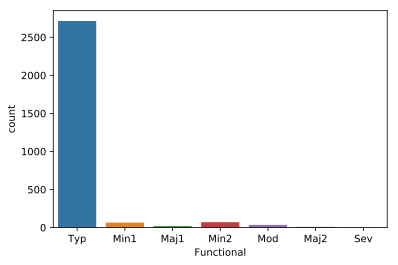

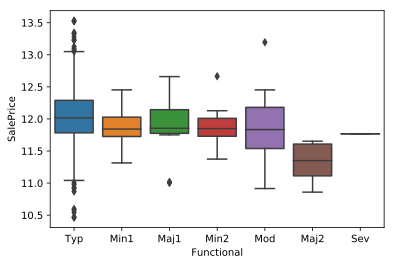

In [83]:
display(merged_data.Functional.value_counts())

sns.countplot(merged_data.Functional)
plt.show()
sns.boxplot(x=var, y='SalePrice', data=train_data)

In [84]:
merged_data['Functional'] = merged_data.Functional.map({'Maj2':0, 'Mod':1, 'Sev':1, 'Min2':1, 'Min1':1, 'Maj1':1, 'Typ':2})
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

2.0    2714
1.0     191
0.0       9
Name: Functional, dtype: int64

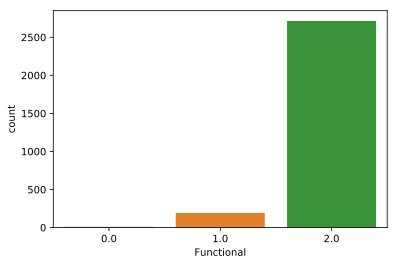

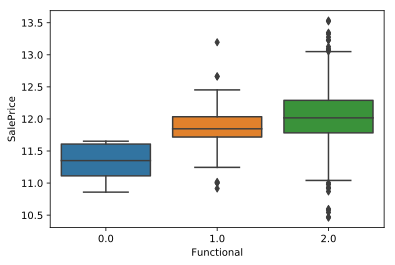

In [85]:
display(merged_data.Functional.value_counts())

sns.countplot(merged_data.Functional)
plt.show()
sns.boxplot(x=var, y='SalePrice', data=train_data)

In [86]:
###################################
# Fireplaces, FireplaceQu
###################################
for var in ['Fireplaces','FireplaceQu']:
    missing_counts = merged_data[var].shape[0] - merged_data[var].count()
    display("There are %d missing values in %s" % (missing_counts,var))

'There are 0 missing values in Fireplaces'

'There are 1419 missing values in FireplaceQu'

In [87]:
merged_data.loc[merged_data.Fireplaces==0, 'FireplaceQu'] = 'NA'
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

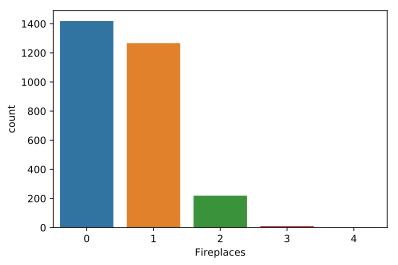

0    689
1    649
2    115
3      4
Name: Fireplaces, dtype: int64

0    730
1    618
2    104
3      6
4      1
Name: Fireplaces, dtype: int64

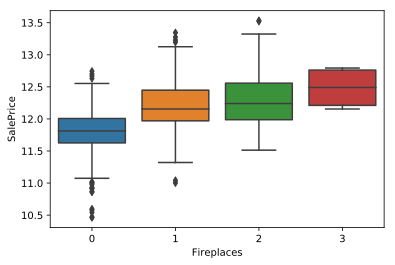

In [88]:
var= 'Fireplaces'
sns.countplot(merged_data[var])
plt.show()
sns.boxplot(x=var, y='SalePrice', data=train_data)
display(train_data[var].value_counts())
display(test_data[var].value_counts())

In [89]:
###################################
# PoolArea, PoolQC
###################################
for var in ['PoolArea','PoolQC']:
    missing_counts = merged_data[var].shape[0] - merged_data[var].count()
    display("There are %d missing values in %s" % (missing_counts,var))

'There are 0 missing values in PoolArea'

'There are 2907 missing values in PoolQC'

In [90]:
merged_data.loc[merged_data.PoolArea==0, 'PoolQC'] = 'NA'


In [91]:
merged_data.loc[merged_data.PoolQC.isna(), 'PoolQC'] = merged_data.loc[merged_data.PoolQC.notna(),'PoolQC'].mode()[0]
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

In [92]:
####################################
# WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
####################################
for var in ['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']:
    missing_counts = merged_data[var].shape[0] - merged_data[var].count()
    display("There are %d missing values in %s" % (missing_counts,var))


'There are 0 missing values in WoodDeckSF'

'There are 0 missing values in OpenPorchSF'

'There are 0 missing values in EnclosedPorch'

'There are 0 missing values in 3SsnPorch'

'There are 0 missing values in ScreenPorch'

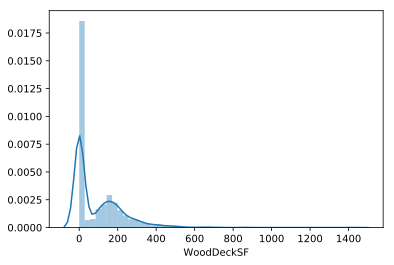

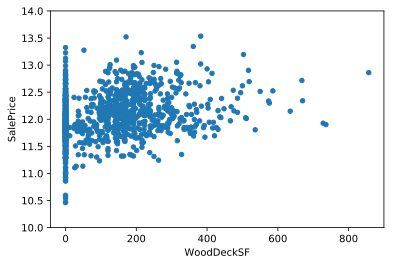

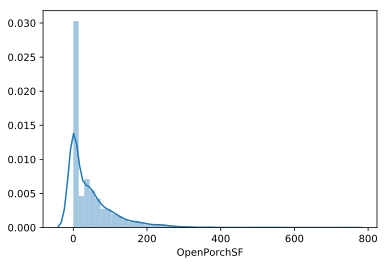

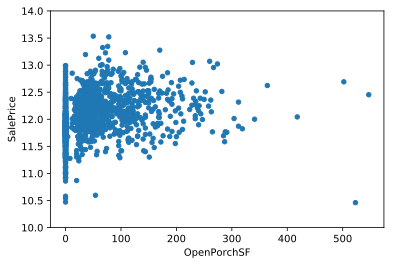

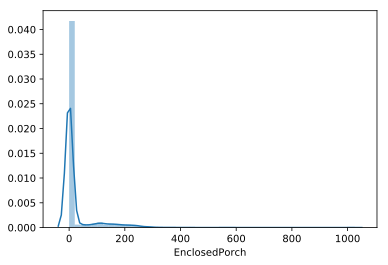

In [ ]:
for var in ['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']:
    sns.distplot(merged_data[var])
    plt.show()
    train_data.plot.scatter(x=var, y='SalePrice', ylim=(10,14))
    plt.show()

In [ ]:
####################################
# MiscFeature,MiscVal
####################################
for var in ['MiscFeature','MiscVal']:
    missing_counts = merged_data[var].shape[0] - merged_data[var].count()
    display("There are %d missing values in %s" % (missing_counts,var))

In [ ]:
merged_data.MiscFeature.fillna("NA", inplace=True)
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

In [ ]:
sns.countplot(merged_data.MiscFeature)
display(train_data.MiscFeature.value_counts())
display(test_data.MiscFeature.value_counts())
plt.show()
sns.boxplot(x='MiscFeature', y='SalePrice', data=train_data)

In [ ]:
merged_data.loc[(merged_data.MiscFeature=='NA')| (merged_data.MiscFeature == 'Othr') | (merged_data.MiscFeature =='TenC'), 'MiscFeature'] = "NA"
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]

In [ ]:
sns.countplot(merged_data.MiscFeature)
display(train_data.MiscFeature.value_counts())
display(test_data.MiscFeature.value_counts())
plt.show()
sns.boxplot(x='MiscFeature', y='SalePrice', data=train_data)

In [ ]:
#############################################
# PavedDrive
#############################################
for var in ['PavedDrive']:
    missing_counts = merged_data[var].shape[0] - merged_data[var].count()
    display("There are %d missing values in %s" % (missing_counts,var))

In [ ]:
sns.countplot(merged_data.PavedDrive)
display(train_data.PavedDrive.value_counts())
display(test_data.PavedDrive.value_counts())


In [ ]:
sns.boxplot(x='PavedDrive', y='SalePrice', data=train_data)

In [ ]:
merged_data['PavedDrive']=merged_data.PavedDrive.map({"N":0, "P":1, "Y":2})
train_data=merged_data.loc[merged_data.SalePrice.notna()]
test_data=merged_data.loc[merged_data.SalePrice.isna()]
aaa

In [ ]:
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [ ]:
var='Condition1'
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=train_data)
fig.axis(ymin=10, ymax=15)
plt.show()
absolute_and_relative_freq(train_data.Condition2)

In [ ]:
k = 20 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
print cols
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12, 9))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train_data[cols], size = 2.5)
plt.show();


In [ ]:
total = merged_data.isnull().sum().sort_values(ascending=False)
percent = (merged_data.isnull().sum()/merged_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)


In [ ]:
NumStr = ["MSSubClass"]#,"BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","LowQualFinSF"]#,"MoSold","YrSold","YearBuilt","YearRemodAdd",,"GarageYrBlt"]
for col in NumStr:
    merged_data[col]=merged_data[col].astype(str)

In [ ]:
cols=["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    merged_data[col].fillna(0, inplace=True)
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    merged_data[col].fillna("None", inplace=True)
cols2 = ["GarageYrBlt","MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    merged_data[col].fillna(merged_data[col].mode()[0], inplace=True)

In [ ]:
merged_data['GrLivArea'] = np.log1p(merged_data['GrLivArea'])
merged_data['TotalBsmtSF'] = np.log1p(merged_data['TotalBsmtSF'])

In [ ]:
def map_values():
    merged_data["oMSSubClass"] = merged_data.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    merged_data["oMSZoning"] = merged_data.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    merged_data["oNeighborhood"] = merged_data.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    merged_data["oCondition1"] = merged_data.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    
    merged_data["oBldgType"] = merged_data.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    merged_data["oHouseStyle"] = merged_data.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    merged_data["oExterior1st"] = merged_data.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    merged_data["oMasVnrType"] = merged_data.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    merged_data["oExterQual"] = merged_data.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    merged_data["oFoundation"] = merged_data.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    merged_data["oBsmtQual"] = merged_data.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    merged_data["oBsmtExposure"] = merged_data.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    merged_data["oHeating"] = merged_data.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    merged_data["oHeatingQC"] = merged_data.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    merged_data["oKitchenQual"] = merged_data.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    merged_data["oFunctional"] = merged_data.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    merged_data["oFireplaceQu"] = merged_data.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    merged_data["oGarageType"] = merged_data.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    merged_data["oGarageFinish"] = merged_data.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    merged_data["oPavedDrive"] = merged_data.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    merged_data["oSaleType"] = merged_data.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    merged_data["oSaleCondition"] = merged_data.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                
                        
                        
    
    return "Done!"


In [ ]:
train_data=merged_data.loc[merged_data['SalePrice'].notnull()]

In [ ]:
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(24, 24))
sns.heatmap(corrmat, vmax=.8, square=True)

In [ ]:
k = 30 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
print cols
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(24, 18))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
map_values()


In [ ]:
merged_data.isnull().sum()[merged_data.isnull().sum()>0]


In [ ]:
corrmat = train_data.corr()
f, ax = plt.subplots(figsize=(24, 24))
sns.heatmap(corrmat, vmax=.8, square=True)

In [ ]:
k = 30 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
print cols
cm = np.corrcoef(train_data[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(24, 18))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [ ]:
merged_data.oBsmtQual.head()

In [ ]:
train_data.columns

In [ ]:
class labelenc(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        lab=LabelEncoder()
        X["YearBuilt"] = lab.fit_transform(X["YearBuilt"])
        X["YearRemodAdd"] = lab.fit_transform(X["YearRemodAdd"])
        X["GarageYrBlt"] = lab.fit_transform(X["GarageYrBlt"])
        return X

In [ ]:
class slim(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.selected_columns = np.unique(['Id','SalePrice','oNeighborhood','OverallQual','OverallCond','LotArea','GrLivArea','1stFlrSF','BsmtFinSF1','oBsmtExposure',
           'MSZoning','GarageCars','CentralAir','KitchenQual','oFunctional','oKitchenQual','BsmtQual','oSaleCondition',
           'BsmtFullBath','Fireplaces','ExterQual','YearRemodAdd','oMSZoning','oHeatingQC','oExterQual','oBsmtQual',
           'oFireplaceQu','Foundation','SaleCondition','oGarageFinish','oCondition1',
           'WoodDeckSF','oExterior1st','HalfBath','oSaleType','oMSSubClass','oPavedDrive','YearBuilt',
           'Condition1','TotalBsmtSF','LotConfig','ScreenPorch',
           'Exterior1st','MasVnrType','GarageYrBlt','GarageFinish','GarageCond','Heating',
           'BsmtFullBath','LowQualFinSF','OpenPorchSF'])

    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X=X[:]
        return X

In [ ]:

class pca_transform(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.selected_columns = np.unique(['Id','SalePrice','oNeighborhood','OverallQual','OverallCond','LotArea','GrLivArea','1stFlrSF','BsmtFinSF1','oBsmtExposure',
           'MSZoning','GarageCars','CentralAir','KitchenQual','oFunctional','oKitchenQual','BsmtQual','oSaleCondition',
           'BsmtFullBath','Fireplaces','ExterQual','YearRemodAdd','oMSZoning','oHeatingQC','oExterQual','oBsmtQual',
           'oFireplaceQu','Foundation','SaleCondition','oGarageFinish','oCondition1',
           'WoodDeckSF','oExterior1st','HalfBath','oSaleType','oMSSubClass','oPavedDrive','YearBuilt',
           'Condition1','TotalBsmtSF','LotConfig','ScreenPorch',
           'Exterior1st','MasVnrType','GarageYrBlt','GarageFinish','GarageCond','Heating',
           'BsmtFullBath','LowQualFinSF','OpenPorchSF'])

    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        temp_cols = X['Id','SalePrice']
        
        pca = PCA(n_components=0.95)
        X_scaled=pca.fit_transform(X)
        print pca.explained_variance_ratio_
        print pca.explained_variance_
        print pca.n_components_

        return X_scaled

In [ ]:
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        X = pd.get_dummies(X)
        return X

In [ ]:
def factorize(df, factor_df, column, fill_na=None):
    factor_df[column] = df[column]
    if fill_na is not None:
        factor_df[column].fillna(fill_na, inplace=True)
    le.fit(factor_df[column].unique())
    factor_df[column] = le.transform(factor_df[column])
    return factor_df

# Combine all the (numerical) features into one big DataFrame. We don't add 
# the one-hot encoded variables here yet, that happens later on.
class munge(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        new_X = pd.DataFrame(index = X.index)
       
        new_X['LotFrontage'] = X['LotFrontage']   
        for key, group in lot_frontage_by_neighborhood:
            idx = (X['Neighborhood'] == key) & (X['LotFrontage'].isnull())
            new_X.loc[idx, 'LotFrontage'] = group.median()    
    
        new_X['LotArea'] = X['LotArea']
    
        new_X['MasVnrArea'] = X['MasVnrArea']
        new_X['MasVnrArea'].fillna(0, inplace=True)
       
        new_X['BsmtFinSF1'] = X['BsmtFinSF1']
        new_X['BsmtFinSF1'].fillna(0, inplace=True)
    
        new_X['BsmtFinSF2'] = X['BsmtFinSF2']
        new_X['BsmtFinSF2'].fillna(0, inplace=True)
    
        new_X['BsmtUnfSF'] = X['BsmtUnfSF']
        new_X['BsmtUnfSF'].fillna(0, inplace=True)
    
        new_X['TotalBsmtSF'] = X['TotalBsmtSF']
        new_X['TotalBsmtSF'].fillna(0, inplace=True)
    
        new_X['1stFlrSF'] = X['1stFlrSF']
        new_X['2nXlrSF'] = X['2nXlrSF']
        new_X['GrLivArea'] = X['GrLivArea']
        
        new_X['GarageArea'] = X['GarageArea']
        new_X['GarageArea'].fillna(0, inplace=True)
    
        new_X['WoodDeckSF'] = X['WoodDeckSF']
        new_X['OpenPorchSF'] = X['OpenPorchSF']
        new_X['EnclosedPorch'] = X['EnclosedPorch']
        new_X['3SsnPorch'] = X['3SsnPorch']
        new_X['ScreenPorch'] = X['ScreenPorch']
        
        new_X['BsmtFullBath'] = X['BsmtFullBath']
        new_X['BsmtFullBath'].fillna(0, inplace=True)
    
        new_X['BsmtHalfBath'] = X['BsmtHalfBath']
        new_X['BsmtHalfBath'].fillna(0, inplace=True)
    
        new_X['FullBath'] = X['FullBath'] 
        new_X['HalfBath'] = X['HalfBath'] 
        new_X['BedroomAbvGr'] = X['BedroomAbvGr'] 
        new_X['KitchenAbvGr'] = X['KitchenAbvGr'] 
        new_X['TotRmsAbvGrd'] = X['TotRmsAbvGrd'] 
        new_X['Fireplaces'] = X['Fireplaces'] 
    
        new_X['GarageCars'] = X['GarageCars']
        new_X['GarageCars'].fillna(0, inplace=True)
    
        new_X['CentralAir'] = (X['CentralAir'] == 'Y') * 1.0
       
        new_X['OverallQual'] = X['OverallQual']
        new_X['OverallCond'] = X['OverallCond']
    
        # Quality measurements are stored as text but we can convert them to 
        # numbers where a higher number means higher quality.
    
        qual_dict = {None: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        new_X['ExterQual'] = X['ExterQual'].map(qual_dict).astype(int)
        new_X['ExterCond'] = X['ExterCond'].map(qual_dict).astype(int)
        new_X['BsmtQual'] = X['BsmtQual'].map(qual_dict).astype(int)
        new_X['BsmtCond'] = X['BsmtCond'].map(qual_dict).astype(int)
        new_X['HeatingQC'] = X['HeatingQC'].map(qual_dict).astype(int)
        new_X['KitchenQual'] = X['KitchenQual'].map(qual_dict).astype(int)
        new_X['FireplaceQu'] = X['FireplaceQu'].map(qual_dict).astype(int)
        new_X['GarageQual'] = X['GarageQual'].map(qual_dict).astype(int)
        new_X['GarageCond'] = X['GarageCond'].map(qual_dict).astype(int)
    
        new_X['BsmtExposure'] = X['BsmtExposure'].map(
            {None: 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}).astype(int)
    
        bsmt_fin_dict = {None: 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
        new_X['BsmtFinType1'] = X['BsmtFinType1'].map(bsmt_fin_dict).astype(int)
        new_X['BsmtFinType2'] = X['BsmtFinType2'].map(bsmt_fin_dict).astype(int)
    
        new_X['Functional'] = X['Functional'].map(
            {None: 0, 'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 
             'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}).astype(int)
    
        new_X['GarageFinish'] = X['GarageFinish'].map(
            {None: 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}).astype(int)
    
        new_X['Fence'] = X['Fence'].map(
            {None: 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}).astype(int)
    
        new_X['YearBuilt'] = X['YearBuilt']
        new_X['YearRemodAdd'] = X['YearRemodAdd']
    
        new_X['GarageYrBlt'] = X['GarageYrBlt']
        new_X['GarageYrBlt'].fillna(0.0, inplace=True)
    
        new_X['MoSold'] = X['MoSold']
        new_X['YrSold'] = X['YrSold']
        
        new_X['LowQualFinSF'] = X['LowQualFinSF']
        new_X['MiscVal'] = X['MiscVal']
    
        new_X['PoolQC'] = X['PoolQC'].map(qual_dict).astype(int)
    
        new_X['PoolArea'] = X['PoolArea']
        new_X['PoolArea'].fillna(0, inplace=True)
        
        # Add categorical features as numbers too. It seems to help a bit.
        new_X = factorize(X, new_X, 'MSSubClass')
        new_X = factorize(X, new_X, 'MSZoning', 'RL')
        new_X = factorize(X, new_X, 'LotConfig')
        new_X = factorize(X, new_X, 'Neighborhood')
        new_X = factorize(X, new_X, 'Condition1')
        new_X = factorize(X, new_X, 'BldgType')
        new_X = factorize(X, new_X, 'HouseStyle')
        new_X = factorize(X, new_X, 'RoofStyle')
        new_X = factorize(X, new_X, 'Exterior1st', 'Other')
        new_X = factorize(X, new_X, 'Exterior2nd', 'Other')
        new_X = factorize(X, new_X, 'MasVnrType', 'None')
        new_X = factorize(X, new_X, 'Foundation')
        new_X = factorize(X, new_X, 'SaleType', 'Oth')
        new_X = factorize(X, new_X, 'SaleCondition')
    
        # IR2 and IR3 don't appear that often, so just make a distinction
        # between regular and irregular.
        new_X['IsRegularLotShape'] = (X['LotShape'] == 'Reg') * 1
    
        # Most properties are level; bin the other possibilities together
        # as 'not level'.
        new_X['IsLandLevel'] = (X['LandContour'] == 'Lvl') * 1
    
        # Most land slopes are gentle; treat the others as 'not gentle'.
        new_X['IsLandSlopeGentle'] = (X['LandSlope'] == 'Gtl') * 1
    
        # Most properties use standard circuit breakers.
        new_X['IsElectricalSBrkr'] = (X['Electrical'] == 'SBrkr') * 1
    
        # About 2/3rd have an attached garage.
        new_X['IsGarageDetached'] = (X['GarageType'] == 'Detchd') * 1
    
        # Most have a paved drive. Treat dirt/gravel and partial pavement
        # as 'not paved'.
        new_X['IsPavedDrive'] = (X['PavedDrive'] == 'Y') * 1
    
        # The only interesting 'misc. feature' is the presence of a shed.
        new_X['HasShed'] = (X['MiscFeature'] == 'Shed') * 1.  
    
        # If YearRemodAdd != YearBuilt, then a remodeling took place at some point.
        new_X['Remodeled'] = (new_X['YearRemodAdd'] != new_X['YearBuilt']) * 1
        
        # Did a remodeling happen in the year the house was sold?
        new_X['RecentRemodel'] = (new_X['YearRemodAdd'] == new_X['YrSold']) * 1
        
        # Was this house sold in the year it was built?
        new_X['VeryNewHouse'] = (new_X['YearBuilt'] == new_X['YrSold']) * 1
    
        new_X['Has2nXloor'] = (new_X['2nXlrSF'] == 0) * 1
        new_X['HasMasVnr'] = (new_X['MasVnrArea'] == 0) * 1
        new_X['HasWoodDeck'] = (new_X['WoodDeckSF'] == 0) * 1
        new_X['HasOpenPorch'] = (new_X['OpenPorchSF'] == 0) * 1
        new_X['HasEnclosedPorch'] = (new_X['EnclosedPorch'] == 0) * 1
        new_X['Has3SsnPorch'] = (new_X['3SsnPorch'] == 0) * 1
        new_X['HasScreenPorch'] = (new_X['ScreenPorch'] == 0) * 1
    
        # These features actually lower the score a little.
        # new_X['HasBasement'] = X['BsmtQual'].isnull() * 1
        # new_X['HasGarage'] = X['GarageQual'].isnull() * 1
        # new_X['HasFireplace'] = X['FireplaceQu'].isnull() * 1
        # new_X['HasFence'] = X['Fence'].isnull() * 1
    
        # Months with the largest number of deals may be significant.
        new_X['HighSeason'] = X['MoSold'].replace( 
            {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})
    
        new_X['NewerDwelling'] = X['MSSubClass'].replace(
            {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
             90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   
        
        new_X.loc[X.Neighborhood == 'NridgHt', 'Neighborhood_Good'] = 1
        new_X.loc[X.Neighborhood == 'Crawfor', 'Neighborhood_Good'] = 1
        new_X.loc[X.Neighborhood == 'StoneBr', 'Neighborhood_Good'] = 1
        new_X.loc[X.Neighborhood == 'Somerst', 'Neighborhood_Good'] = 1
        new_X.loc[X.Neighborhood == 'NoRidge', 'Neighborhood_Good'] = 1
        new_X['Neighborhood_Good'].fillna(0, inplace=True)
    
        new_X['SaleCondition_PriceDown'] = X.SaleCondition.replace(
            # {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})
            {'Abnorml': 1, 'Alloca': 2, 'AdjLand': 3, 'Family': 4, 'Normal': 5, 'Partial': 0})
    
        # House completed before sale or not
        new_X['BoughtOffPlan'] = X.SaleCondition.replace(
            {'Abnorml' : 0, 'Alloca' : 0, 'AdjLand' : 0, 'Family' : 0, 'Normal' : 0, 'Partial' : 1})
        
        # new_X['BadHeating'] = X.HeatingQC.replace(
        #     {'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})
        new_X['BadHeating'] = X.HeatingQC.replace(
            {'Ex': 0, 'Gd': 1, 'TA': 2, 'Fa': 3, 'Po': 4})
    
        area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                     'TotalBsmtSF', '1stFlrSF', '2nXlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                     'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
        new_X['TotalArea'] = new_X[area_cols].sum(axis=1)
    
        new_X['TotalArea1st2nd'] = new_X['1stFlrSF'] + new_X['2nXlrSF']
    
        new_X['Age'] = 2010 - new_X['YearBuilt']
        new_X['TimeSinceSold'] = 2010 - new_X['YrSold']
    
        # If commented - a little bit worse on LB but better in CV
        new_X['SeasonSold'] = new_X['MoSold'].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                      6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
        
        new_X['YearsSinceRemodel'] = new_X['YrSold'] - new_X['YearRemodAdd']
        
        # Simplifications of existing features into bad/average/good.
        # new_X['SimplOverallQual'] = new_X.OverallQual.replace(
        #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
        # new_X['SimplOverallCond'] = new_X.OverallCond.replace(
        #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
        # new_X['SimplPoolQC'] = new_X.PoolQC.replace(
        #     {1 : 1, 2 : 1, 3 : 2, 4 : 2})
        # new_X['SimplGarageCond'] = new_X.GarageCond.replace(
        #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
        # new_X['SimplGarageQual'] = new_X.GarageQual.replace(
        #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
        # new_X['SimplFireplaceQu'] = new_X.FireplaceQu.replace(
        #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
        # new_X['SimplFireplaceQu'] = new_X.FireplaceQu.replace(
        #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
        # new_X['SimplFunctional'] = new_X.Functional.replace(
        #     {1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
        # new_X['SimplKitchenQual'] = new_X.KitchenQual.replace(
        #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
        # new_X['SimplHeatingQC'] = new_X.HeatingQC.replace(
        #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
        # new_X['SimplBsmtFinType1'] = new_X.BsmtFinType1.replace(
        #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
        # new_X['SimplBsmtFinType2'] = new_X.BsmtFinType2.replace(
        #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
        # new_X['SimplBsmtCond'] = new_X.BsmtCond.replace(
        #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
        # new_X['SimplBsmtQual'] = new_X.BsmtQual.replace(
        #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
        # new_X['SimplExterCond'] = new_X.ExterCond.replace(
        #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
        # new_X['SimplExterQual'] = new_X.ExterQual.replace(
        #     {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    
        new_X['SimplOverallQual'] = new_X.OverallQual
        new_X['SimplOverallCond'] = new_X.OverallCond
        new_X['SimplPoolQC'] = new_X.PoolQC
        new_X['SimplGarageCond'] = new_X.GarageCond
        new_X['SimplGarageQual'] = new_X.GarageQual
        new_X['SimplFireplaceQu'] = new_X.FireplaceQu
        new_X['SimplFireplaceQu'] = new_X.FireplaceQu
        new_X['SimplFunctional'] = new_X.Functional
        new_X['SimplKitchenQual'] = new_X.KitchenQual
        new_X['SimplHeatingQC'] = new_X.HeatingQC
        new_X['SimplBsmtFinType1'] = new_X.BsmtFinType1
        new_X['SimplBsmtFinType2'] = new_X.BsmtFinType2
        new_X['SimplBsmtCond'] = new_X.BsmtCond
        new_X['SimplBsmtQual'] = new_X.BsmtQual
        new_X['SimplExterCond'] = new_X.ExterCond
        new_X['SimplExterQual'] = new_X.ExterQual
                
        # Bin by neighborhood (a little arbitrarily). Values were computed by: 
        # train_X['SalePrice'].groupby(train_X['Neighborhood']).median().sort_values()
        neighborhood_map = {
            'MeadowV' : 0,  #  88000
            'IDOTRR' : 1,   # 103000
            'BrDale' : 1,   # 106000
            'OldTown' : 1,  # 119000
            'Edwards' : 1,  # 119500
            'BrkSide' : 1,  # 124300
            'Sawyer' : 1,   # 135000
            'Blueste' : 1,  # 137500
            'SWISU' : 2,    # 139500
            'NAmes' : 2,    # 140000
            'NPkVill' : 2,  # 146000
            'Mitchel' : 2,  # 153500
            'SawyerW' : 2,  # 179900
            'Gilbert' : 2,  # 181000
            'NWAmes' : 2,   # 182900
            'Blmngtn' : 2,  # 191000
            'CollgCr' : 2,  # 197200
            'ClearCr' : 3,  # 200250
            'Crawfor' : 3,  # 200624
            'Veenker' : 3,  # 218000
            'Somerst' : 3,  # 225500
            'Timber' : 3,   # 228475
            'StoneBr' : 4,  # 278000
            'NoRidge' : 4,  # 290000
            'NridgHt' : 4,  # 315000
        }
    
        new_X['NeighborhoodBin'] = X['Neighborhood'].map(neighborhood_map)
        return new_X
    

In [ ]:
pipe = Pipeline([
    ('deal_missing', deal_missing()),
    ('labenc', labelenc()),
    ('skew_dummies', skew_dummies(skew=1)),
    ])

In [ ]:
data_pipe = pipe.fit_transform(merged_data)


In [ ]:
data_pipe.columns

In [ ]:

slim_merged_data = data_pipe[:]
#slim_merged_data.drop('LotFrontage', axis=1,inplace=True)
for col in drop_cols:
    if col in slim_merged_data.columns:
        slim_merged_data.drop(col, axis=1, inplace=True)


In [ ]:
slim_merged_data.head()

In [ ]:
import xgboost as xgb
slim_merged_data_with_dummies = pd.get_dummies(slim_merged_data)
train_data=slim_merged_data_with_dummies.loc[slim_merged_data_with_dummies['SalePrice'].notnull()]
train_data.pop('Id')
training_y = train_data.pop('SalePrice')

test_data = slim_merged_data_with_dummies.loc[slim_merged_data_with_dummies['SalePrice'].isnull()]
test_data.pop("SalePrice")
ids = test_data.pop('Id')


In [ ]:
training_y.head()

In [ ]:
def pretty_print_linear(coefs, names = None, sort = True):
    
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    
    lst = zip(coefs, names)
    
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
        
    f = lambda coef, name:"%f * %s"%(round(coef,3), name)
    
    return "+".join([f(coef, name) for (coef,name) in lst])

In [ ]:
from sklearn.linear_model import RandomizedLasso
X=train_data
Y=training_y
rlasso = RandomizedLasso(alpha=0.00025, max_iter=10000)
rlasso.fit(X, Y)
names=train_data.columns
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
                 names), reverse=True)


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso


lasso = Lasso(alpha=0.0001, copy_X=False, fit_intercept=True, max_iter=10000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
lasso.fit(X,Y)


In [ ]:
lasso.coef_

In [ ]:
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 'n_estimators':100,
             'objective': 'gpu:reg:linear', 'eval_metric':'rmse','max_depth':5, 'min_child_weight':1} 
clf = xgb.XGBModel(**our_params)

clf = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,objective="gpu:reg:linear",
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

clf.fit(train_data, training_y, verbose=True)




In [ ]:
predictions = clf.predict(test_data)
submission = pd.DataFrame({"Id": ids, "SalePrice": np.expm1(predictions)})
submission.to_csv("submission12.csv", index=False)

#print(explained_variance_score(predictions,training_y))



In [ ]:
from sklearn.cross_validation import train_test_split

from sklearn.cross_validation import *
from sklearn.grid_search import GridSearchCV

xgb_model=xgb.XGBRegressor(n_jobs=1,nthread=-1,objective="reg:linear")

params = {'min_child_weight':[1,2,3,4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(4,11)],
          'colsample_bytree':[i/10.0 for i in range(4,11)], 'max_depth': [2,3,4,5,6,7,8,9,10]}

clf = GridSearchCV(xgb_model, params, n_jobs=5, 
                   cv=StratifiedKFold(Y, n_folds=5, shuffle=True), 
                   scoring='neg_mean_squared_error',
                   verbose=2, refit=True)

clf.fit(X, Y)

#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

test_probs = clf.predict(test_data)

test_probs = clf.best_estimator_.predict(test_data)

print Y,test_probs
submission = pd.DataFrame({"Id": ids, "SalePrice": np.logm1(test_probs)})

submission.to_csv("xgboost_best_parameter_submission.csv", index=False)


In [ ]:
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))


In [ ]:
print predictions